Data downloaded from (access data 09/21/2025): https://www.uniprot.org/help/embeddings

In [16]:
import os
import math
import h5py
import numpy as np
from typing import Callable, Any, Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

import matplotlib.pyplot as plt

## Reproducibility & speed

In [17]:
def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

## Training & eval helpers &  Data loading

In [18]:
def build_loaders(X: torch.Tensor, batch_size: int = 256, num_workers: int = 2):
    N = len(X)
    n_train = int(0.8 * N)
    n_val = int(0.1 * N)
    n_test = N - n_train - n_val
    ds = TensorDataset(X)
    train_set, val_set, test_set = random_split(
        ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42)
    )

    def make_loader(dset, shuffle=False):
        return DataLoader(
            dset,
            batch_size=batch_size,
            shuffle=shuffle,
            pin_memory=True,
            num_workers=num_workers,
            drop_last=False,
        )

    return make_loader(train_set, True), make_loader(val_set), make_loader(test_set)


def load_h5_embeddings(path: str) -> torch.Tensor:
    with h5py.File(path, "r") as f:
        protein_ids = list(f.keys())
        embeddings = [f[pid][()] for pid in protein_ids]
    X = torch.tensor(np.stack(embeddings), dtype=torch.float32)
    return X


## Losses

In [19]:
def normalized_mean_squared_error(
    reconstruction: torch.Tensor,
    original_input: torch.Tensor,
) -> torch.Tensor:
    return (
        ((reconstruction - original_input) ** 2).mean(dim=1) / (original_input**2).mean(dim=1)
    ).mean()


def normalized_L1_loss(
    latent_activations: torch.Tensor,
    original_input: torch.Tensor,
) -> torch.Tensor:
    return (latent_activations.abs().sum(dim=1) / original_input.norm(dim=1)).mean()


def autoencoder_loss(
    reconstruction: torch.Tensor,
    original_input: torch.Tensor,
    latent_activations: torch.Tensor,
    l1_weight: float,
) -> torch.Tensor:
    return (
        normalized_mean_squared_error(reconstruction, original_input)
        + normalized_L1_loss(latent_activations, original_input) * l1_weight
    )

In [20]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GRAD_CLIP_NORM = 1.0  # set to None to disable
USE_COSINE = True     # cosine LR with warmup


# =========================
# Non-trainable LayerNorm
# =========================
def layer_norm_no_affine(
    x: torch.Tensor, eps: float = 1e-5
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Non-trainable LayerNorm over the last dim; returns (x_norm, mean, std).
    """
    mu = x.mean(dim=-1, keepdim=True)
    x_center = x - mu
    var = (x_center ** 2).mean(dim=-1, keepdim=True)
    std = torch.sqrt(var + eps)
    return x_center / std, mu, std


# =========================
# Weight tying wrapper
# =========================
class TiedTranspose(nn.Module):
    def __init__(self, linear: nn.Linear):
        super().__init__()
        self.linear = linear

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert self.linear.bias is None
        return F.linear(x, self.linear.weight.t(), None)

    @property
    def weight(self) -> torch.Tensor:
        return self.linear.weight.t()

    @property
    def bias(self) -> torch.Tensor:
        return self.linear.bias


# =========================
# Sparse activations
# =========================
class TopK(nn.Module):
    """
    Top-k sparse activation.

    Keeps the k largest values per row (last dimension) and sets all
    others to zero. Optionally applies a post-activation function
    (default: ReLU) to the selected values before reinserting them.
    """

    def __init__(self, k: int, postact_fn: Callable = nn.ReLU()) -> None:
        super().__init__()
        self.k = int(k)
        self.postact_fn = postact_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor of shape [..., d].

        Returns:
            Tensor of the same shape as x, with only the top-k values
            (per last dimension) kept and transformed by postact_fn;
            all other entries are zero.
        """
        topk = torch.topk(x, k=self.k, dim=-1)
        values = self.postact_fn(topk.values)
        result = torch.zeros_like(x)
        result.scatter_(-1, topk.indices, values)
        return result

# =========================
# Sparse Autoencoder
# =========================
class SparseAutoEncoder(nn.Module):
    """
    latents = activation(encoder(x - pre_bias) + latent_bias)
    recons  = decoder(latents) + pre_bias
    """
    def __init__(
        self,
        n_latents: int,
        n_inputs: int,
        activation: Callable = nn.ReLU(),
        tied: bool = True,
        normalize: bool = False,
    ) -> None:
        super().__init__()
        self.pre_bias = nn.Parameter(torch.zeros(n_inputs))

        # ---- Encoder (no bias); Kaiming/He-init like tricks ----
        self.encoder: nn.Linear = nn.Linear(n_inputs, n_latents, bias=False)
        nn.init.kaiming_uniform_(self.encoder.weight)

        self.latent_bias = nn.Parameter(torch.zeros(n_latents))

        # ---- Decoder: tied or free ----
        if tied:
            self.decoder: nn.Module = TiedTranspose(self.encoder)
        else:
            self.decoder = nn.Linear(n_latents, n_inputs, bias=False)
            nn.init.kaiming_uniform_(self.decoder.weight)

        self.activation = activation
        self.normalize = normalize

    def encode_pre_act(self, x: torch.Tensor, latent_slice: slice = slice(None)) -> torch.Tensor:
        x = x - self.pre_bias
        latents_pre_act = F.linear(
            x, self.encoder.weight[latent_slice], self.latent_bias[latent_slice]
        )
        return latents_pre_act

    def preprocess(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, Any]]:
        if not self.normalize:
            return x, {}
        x_norm, mu, std = layer_norm_no_affine(x)
        return x_norm, {"mu": mu, "std": std}

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, Any]]:
        x, info = self.preprocess(x)
        return self.activation(self.encode_pre_act(x)), info

    def decode(self, latents: torch.Tensor, info: Dict[str, Any] | None = None) -> torch.Tensor:
        ret = self.decoder(latents) + self.pre_bias
        if self.normalize:
            assert info is not None
            ret = ret * info["std"] + info["mu"]
        return ret

    def forward(self, x: torch.Tensor):
        x_proc, info = self.preprocess(x)
        latents_pre_act = self.encode_pre_act(x_proc)
        latents = self.activation(latents_pre_act)
        recons = self.decode(latents, info)

        return latents_pre_act, latents, recons

## Train, and eval 

In [21]:
def batch_l0(latents: torch.Tensor) -> float:
    """Counts non-zero activations per sample, then averages across batch."""
    return (latents != 0).sum(dim=1).float().mean().item()

@torch.no_grad()
def evaluate_epoch(model, loader, l1_weight: float) -> Dict[str, float]:
    model.eval()
    losses = []
    mses = []
    l0s = []
    for (x,) in loader:
        x = x.to(DEVICE, non_blocking=True)
        latents_pre, latents, recons = model(x)
        loss = autoencoder_loss(recons, x, latents, l1_weight)
        mse  = normalized_mean_squared_error(recons, x)
        l0   = batch_l0(latents)

        losses.append(loss.item())
        mses.append(mse.item())
        l0s.append(l0)

    return {
        "loss": float(np.mean(losses)),
        "nmse": float(np.mean(mses)),
        "l0":   float(np.mean(l0s)),
    }



def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    *,
    epochs: int = 20,
    lr: float = 1e-3,
    l1_weight: float = 0.0,
    warmup_steps: int = 0,
):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    if USE_COSINE:
        total_steps = epochs * max(1, len(train_loader))
        def lr_lambda(step):
            if step < warmup_steps:
                return max(1e-6, (step + 1) / max(1, warmup_steps))
            prog = (step - warmup_steps) / max(1, total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * min(1.0, max(0.0, prog))))
        sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)
    else:
        sched = None

    history = {
        "train_loss": [], "train_nmse": [], "train_l0": [],
        "val_loss":   [], "val_nmse":   [], "val_l0":   [],
        "test_loss":  [], "test_nmse":  [], "test_l0":  [],
    }

    global_step = 0
    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []
        train_mses = []
        train_l0s = []
        for (x,) in train_loader:
            x = x.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)

            latents_pre, latents, recons = model(x)
            loss_total = autoencoder_loss(recons, x, latents, l1_weight)
            nmse = normalized_mean_squared_error(recons, x)
            l0   = batch_l0(latents)

            loss_total.backward()

            if GRAD_CLIP_NORM is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)

            opt.step()
            if sched is not None:
                sched.step()
            global_step += 1

            train_losses.append(loss_total.item())
            train_mses.append(nmse.item())
            train_l0s.append(l0)

        # Epoch-end eval
        train_loss = float(np.mean(train_losses))
        train_nmse = float(np.mean(train_mses))
        train_l0   = float(np.mean(train_l0s))
        
        val_metrics = evaluate_epoch(model, val_loader, l1_weight)
        test_metrics = evaluate_epoch(model, test_loader, l1_weight)

        history["train_loss"].append(train_loss)
        history["train_nmse"].append(train_nmse)
        history["train_l0"].append(train_l0)
        history["val_loss"].append(val_metrics["loss"])
        history["val_nmse"].append(val_metrics["nmse"])
        history["val_l0"].append(val_metrics["l0"])
        history["test_loss"].append(test_metrics["loss"])
        history["test_nmse"].append(test_metrics["nmse"])
        history["test_l0"].append(test_metrics["l0"])

        print(
            f"Epoch {epoch:02d} | "
            f"train: loss {train_loss:.4f}, nmse {train_nmse:.4f} | "
            f"val: loss {val_metrics['loss']:.4f}, nmse {val_metrics['nmse']:.4f} | "
            f"test: loss {test_metrics['loss']:.4f}, nmse {test_metrics['nmse']:.4f}"
        )

    return history

Epoch 01 | train: loss 0.8870, nmse 0.8820 | val: loss 0.6116, nmse 0.6049 | test: loss 0.6031, nmse 0.5963
Epoch 02 | train: loss 0.4872, nmse 0.4797 | val: loss 0.3967, nmse 0.3885 | test: loss 0.3869, nmse 0.3787
Epoch 03 | train: loss 0.3292, nmse 0.3204 | val: loss 0.2822, nmse 0.2727 | test: loss 0.2738, nmse 0.2643
Epoch 04 | train: loss 0.2432, nmse 0.2330 | val: loss 0.2169, nmse 0.2061 | test: loss 0.2098, nmse 0.1988
Epoch 05 | train: loss 0.1912, nmse 0.1794 | val: loss 0.1764, nmse 0.1638 | test: loss 0.1701, nmse 0.1575
Epoch 06 | train: loss 0.1588, nmse 0.1453 | val: loss 0.1510, nmse 0.1369 | test: loss 0.1456, nmse 0.1314
Epoch 07 | train: loss 0.1381, nmse 0.1234 | val: loss 0.1343, nmse 0.1192 | test: loss 0.1294, nmse 0.1142
Epoch 08 | train: loss 0.1244, nmse 0.1089 | val: loss 0.1226, nmse 0.1070 | test: loss 0.1182, nmse 0.1024
Epoch 09 | train: loss 0.1147, nmse 0.0987 | val: loss 0.1145, nmse 0.0986 | test: loss 0.1104, nmse 0.0943
Epoch 10 | train: loss 0.107

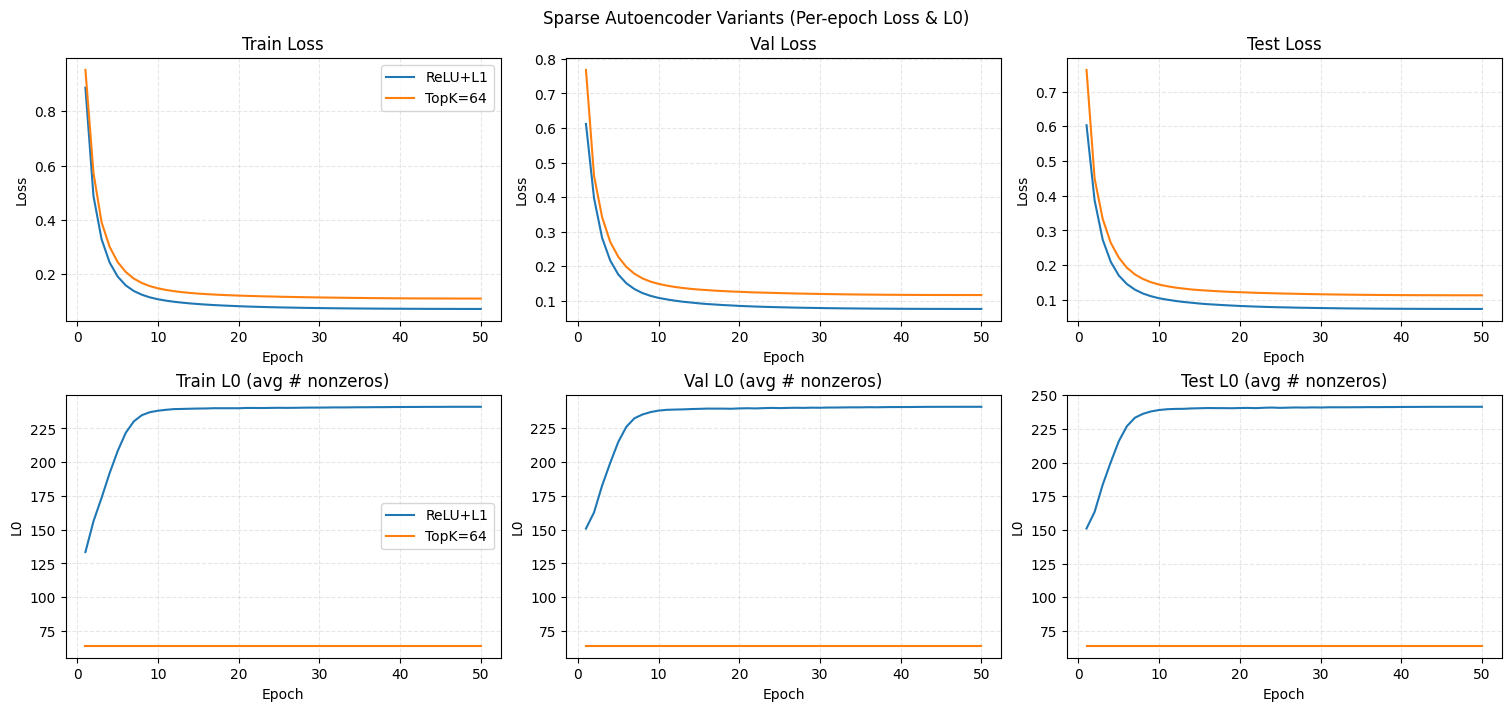

In [22]:
# =========================
# Plotting
# =========================
def plot_summary(histA, histB, title="SAE variants comparison"):
    """
    Builds a 2x2 grid: rows = [Loss, NMSE], cols = [Train, Val, Test]
    Bars = [ReLU+L1, TopK] using the final-epoch values.
    """
    splits = ["train", "val", "test"]
    models = ["ReLU+L1", "TopK=64"]

    # Final epoch values
    final = {
        "ReLU+L1": {
            "loss": [histA["train_loss"][-1], histA["val_loss"][-1], histA["test_loss"][-1]],
            "nmse": [histA["train_nmse"][-1], histA["val_nmse"][-1], histA["test_nmse"][-1]],
        },
        "TopK=64": {
            "loss": [histB["train_loss"][-1], histB["val_loss"][-1], histB["test_loss"][-1]],
            "nmse": [histB["train_nmse"][-1], histB["val_nmse"][-1], histB["test_nmse"][-1]],
        },
    }

    fig, axes = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True)
    width = 0.25
    x = np.arange(len(models))

    for col, split in enumerate(splits):
        # Loss row
        ax = axes[0, col]
        vals = [final[m]["loss"][col] for m in models]
        ax.bar(x, vals, width)
        ax.set_title(f"{split.capitalize()} Loss")
        ax.set_xticks(x, models, rotation=20)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)

        # NMSE row
        ax = axes[1, col]
        vals = [final[m]["nmse"][col] for m in models]
        ax.bar(x, vals, width)
        ax.set_title(f"{split.capitalize()} NMSE")
        ax.set_xticks(x, models, rotation=20)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)

    fig.suptitle(title)
    plt.show()

def plot_curves(histA, histB, title="SAE variants: Loss & L0 per epoch"):
    """
    2x3 grid: rows = [Loss, L0], cols = [Train, Val, Test].
    Lines = [ReLU+L1, TopK=64]. X-axis = epochs.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    splits = ["train", "val", "test"]
    models = [("ReLU+L1", histA), ("TopK=64", histB)]

    fig, axes = plt.subplots(2, 3, figsize=(15, 7), constrained_layout=True)
    epochs = np.arange(1, len(histA["train_loss"]) + 1)

    for col, split in enumerate(splits):
        # Row 0: Loss
        ax = axes[0, col]
        for name, H in models:
            ax.plot(epochs, H[f"{split}_loss"], label=name)
        ax.set_title(f"{split.capitalize()} Loss")
        ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
        ax.grid(True, linestyle="--", alpha=0.3)
        if col == 0: ax.legend()

        # Row 1: L0
        ax = axes[1, col]
        for name, H in models:
            ax.plot(epochs, H[f"{split}_l0"], label=name)
        ax.set_title(f"{split.capitalize()} L0 (avg # nonzeros)")
        ax.set_xlabel("Epoch"); ax.set_ylabel("L0")
        ax.grid(True, linestyle="--", alpha=0.3)
        if col == 0: ax.legend()

    fig.suptitle(title)
    plt.show()


# =========================
# Main run
# =========================
def main():
    # ---- Load data ----
    file_path = "./data/per-protein.h5"
    X = load_h5_embeddings(file_path)  # [N, D]
    n_inputs = X.shape[1]

    # ---- Dataloaders ----
    train_loader, val_loader, test_loader = build_loaders(X, batch_size=256, num_workers=2)

    # ---- Common config ----
    epochs = 50
    lr = 1e-3
    warmup_steps = 500

    # ---- Model A: ReLU SAE (MSE + L1), no TopK ----
    model_a = SparseAutoEncoder(
        n_latents=256,
        n_inputs=n_inputs,
        activation=nn.ReLU(),
        tied=True,               # initialize decoder as encoderᵀ
        normalize=False,         # no LN in this variant
    )
    histA = train_model(
        model_a, train_loader, val_loader, test_loader,
        epochs=epochs, lr=lr, l1_weight=0.001, warmup_steps=warmup_steps
    )

    # ---- Model B: TopK=64 (MSE only) ----
    model_b = SparseAutoEncoder(
        n_latents=256,
        n_inputs=n_inputs,
        activation=TopK(k=64),
        tied=True,
        normalize=True,          # good practice with sparse activations
    )
    histB = train_model(
        model_b, train_loader, val_loader, test_loader,
        epochs=epochs, lr=lr, l1_weight=0.0, warmup_steps=warmup_steps
    )
    
    #plot_summary(histA, histB, title="Sparse Autoencoder Variants (Loss & NMSE)")
    plot_curves(histA, histB, title="Sparse Autoencoder Variants (Per-epoch Loss & L0)")


if __name__ == "__main__":
    main()